# Classification of Two Concentric Circles
In this Notebook we present the code correspondind to the binary classification of two concentric circles problem using a neural network with one hidden layer and different activation functions.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F

import sklearn
from sklearn import datasets
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

import numpy as np
import math
from tqdm import trange

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from matplotlib.ticker import FormatStrFormatter
import imageio

In [2]:
%matplotlib notebook

# Neural Network w/ 1 Hidden Layer

In [32]:
# Define architecture
class NNClassifier(nn.Module):
    _activation_function = dict(tanh=torch.tanh, relu=torch.relu, sin=torch.sin, sq=torch.mul)
    def __init__(self, input_shape, hidden_shape, activation):
        assert activation in self._activation_function, '{} function not available.'.format(activation)
        super().__init__()
        self._hidden_layer = nn.Linear(in_features=input_shape, out_features=hidden_shape)
        self._output_layer = nn.Linear(in_features=hidden_shape, out_features=1)
        self._hidden_shape = hidden_shape
        self._activation = activation
        
    def hidden_layer(self, X):
        if self._activation == 'sq':
            return self._activation_function[self._activation](self._hidden_layer(X), self._hidden_layer(X))
        return self._activation_function[self._activation](self._hidden_layer(X))
    
    def output_layer(self, X):
        return torch.sigmoid(self._output_layer(X))

    def forward(self, X):
        return self.output_layer(self.hidden_layer(X))
    
    def predict(self, X):
        return self.forward(X).clone().detach()
    
    def train(self, X, y, epochs, optimizer, criterion, plot = False, **kwargs):
        losses = []
        im = []
        im_aux = []
            
        for i in range(epochs):
            y_pred = self.forward(X)
            
            loss = criterion(y_pred[:, 0], y)
            losses.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # If plot option true, a gif is generated with the evolution of the prediction
            if plot and (i + 1) in np.logspace(np.log10(1), np.log10(epochs), num=kwargs['num_plots']).round():
                fig = plt.figure(constrained_layout=True, figsize=(9,5))
                #fig, ax = plt.subplots(1, 2, figsize=(7,5))
                gs = fig.add_gridspec(nrows=1, ncols=3)
                ax0 = fig.add_subplot(gs[0, :-1])
                ax1 = fig.add_subplot(gs[0, -1])
                ax1.plot(losses)
                # for the surface evolution
                if kwargs['plot_type'] == 'surface':
                    surface_prediction = self.predict(kwargs['points'])
                    #surface_prediction = self.output_layer(kwargs['points']).detach()
                    ax0.pcolormesh(kwargs['X1'], kwargs['X2'], 
                                  surface_prediction.reshape(kwargs['num_points'], kwargs['num_points']), 
                                  cmap=plt.cm.get_cmap('YlGn'))
                    ax0.scatter(X[:, 0], X[:, 1], c=y)
                    
                    ax0.set(title='Frontier')
                # for the evolution of the points in the hidden space
                else:
                    H = self.hidden_layer(X).detach().numpy()
                    ax0.scatter(H[:, 0], H[:, 1], c=y)
                    ax0.set(title='Hidden Space')
                    
                fig.suptitle('Epoch {}'.format(i))
                image = NNClassifier._aux_plot(fig, ax0, ax1)
                im.append(image)
                im_aux.append(image)
                
        print('Accuracy: {}'.format(accuracy_score(model.predict(X)[:,0].numpy().round(),y.numpy())))
        if plot:
            kwargs_write = {'fps':1.0, 'quantizer':'nq'}
            #imageio.mimsave('{}_init.gif'.format(kwargs['file_name']), im, fps=10)
            imageio.mimsave('{}.gif'.format(kwargs['file_name']), im_aux, fps=10)
        return losses
    
    # auxiliar method for the plots
    @staticmethod
    def _aux_plot(fig, ax0, ax1):
        ax0.axis('equal')
        ax0.get_xaxis().set_visible(False)
        ax0.get_yaxis().set_visible(False)
        ax1.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
        ax1.get_xaxis().set_visible(False)
        ax1.set(title='Loss')
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close(fig)
        return image

In [33]:
# a method to animate a 3d plot
def animate(H, y, xx, yy, z, file_name):
    fig = plt.figure(figsize=(9, 6))
    ax = Axes3D(fig)

    def init():
        ax.plot_surface(xx, yy, z, alpha=0.2)
        ax.scatter3D(H[:, 0], H[:, 1], H[:, 2], c=y)
        return fig,

    def animate(i):
        ax.view_init(elev=20., azim=i)
        return fig,

    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=360, interval=20, blit=True)
    anim.save('{}.gif'.format(file_name), writer='imagemagick', fps=20)
              
    return anim

# Data

<IPython.core.display.Javascript object>


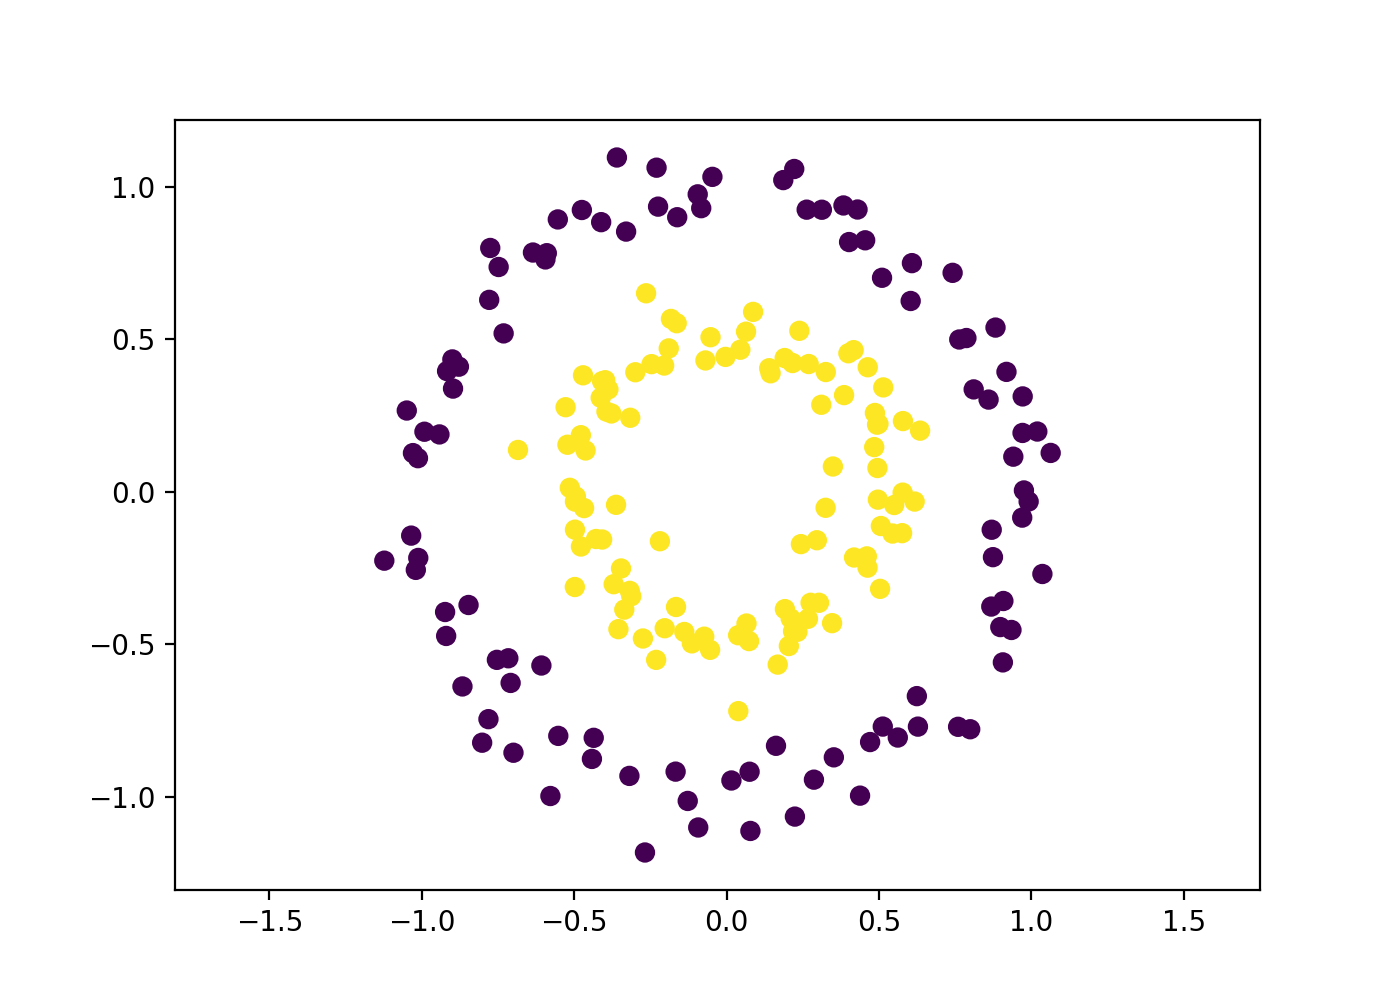

In [96]:
n_samples = 200
X,y = datasets.make_circles(n_samples,noise=0.08, factor=0.5)
fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(X[:,0],X[:,1],s=40,c=y)
ax.axis('equal')
#ax.set_title('n = {}'.format(n_samples))
fig.show()
#plt.savefig('circles_input.png', dpi=300)

In [97]:
# Transform the data to tensor
X = torch.from_numpy(X).type(torch.FloatTensor)
y = torch.from_numpy(y).type(torch.FloatTensor)

# Model

In [123]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = NNClassifier(input_shape=2, hidden_shape=3, activation='tanh').to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# mean-squared error loss
criterion = nn.BCELoss()

## Train

In [124]:
# Training parameters
num_points = 300
x1s = np.linspace(-2, 2, num_points)
x2s = np.linspace(-1.5, 1.5, num_points)
points = np.transpose([np.tile(x1s, len(x2s)), np.repeat(x2s, len(x1s))])
points = torch.from_numpy(points).type(torch.FloatTensor)
X1, X2 = np.meshgrid(x1s, x2s)

num_plots = 150
file_name = 'circles_surface_train_loss_tanh_3'
plot_type = 'surface'
kwargs=dict(num_plots=num_plots, points=points, num_points=num_points, file_name=file_name, X1=X1, X2=X2, plot_type=plot_type)

In [125]:
# run training process
losses = model.train(X, y, 10000, optimizer, criterion, plot=False, **kwargs)
model._hidden_layer.weight

Accuracy: 1.0


Parameter containing:
tensor([[-2.6288,  1.9482],
        [ 0.5044,  3.3590],
        [-3.0546, -1.3045]], requires_grad=True)

<IPython.core.display.Javascript object>


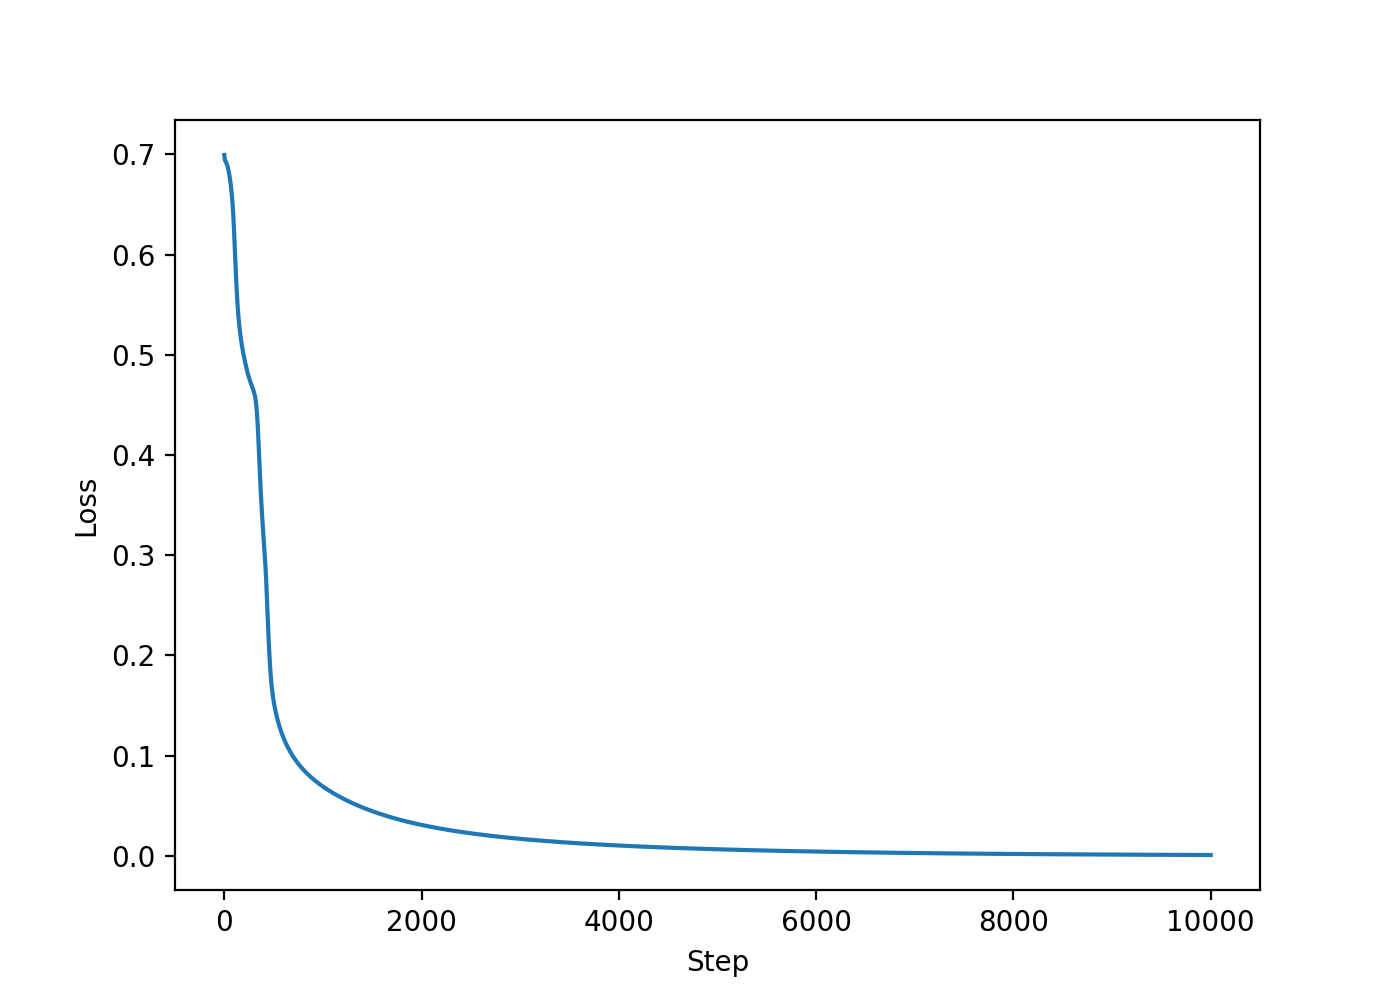

In [126]:
# plot loss evolution
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(losses)
ax.set_xlabel('Step')
ax.set_ylabel('Loss')
fig.show()
#plt.savefig('circles_loss_tanh.png', dpi=300)

## Plot Output

In [127]:
num_points = 300
x1s = np.linspace(-1.7, 1.7, num_points)
x2s = np.linspace(-1.5, 1.5, num_points)
points = np.transpose([np.tile(x1s, len(x2s)), np.repeat(x2s, len(x1s))])
points = torch.from_numpy(points).type(torch.FloatTensor)
y_pred = model.predict(points)
X1, X2 = np.meshgrid(x1s, x2s)

<IPython.core.display.Javascript object>


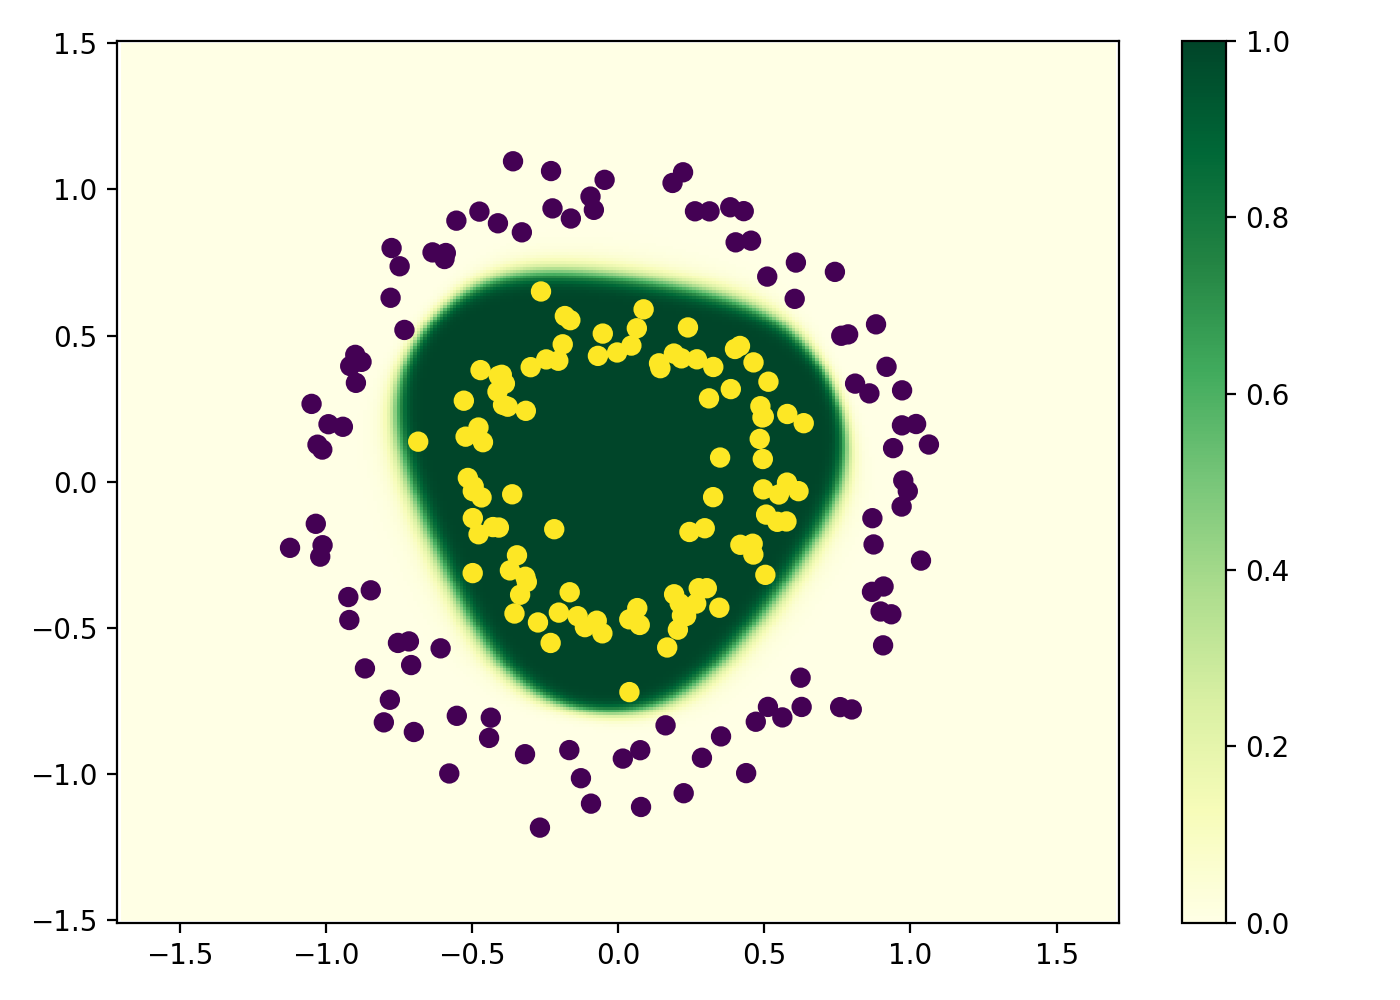

In [128]:
fig, ax = plt.subplots(figsize=(7,5))
im = ax.pcolormesh(X1, X2, y_pred.reshape(300, 300), cmap=plt.cm.get_cmap('YlGn'), )
ax.scatter(X[:,0],X[:,1],s=40,c=y)
ax.axis('equal')
ax.set_title('')
fig.colorbar(im, ax=ax)
fig.tight_layout()
fig.show()
plt.savefig('circles_output_tanh.png', dpi=300)

## Plot Hidden Space

In [129]:
H = model.hidden_layer(X)
H = H.detach().numpy()

<IPython.core.display.Javascript object>


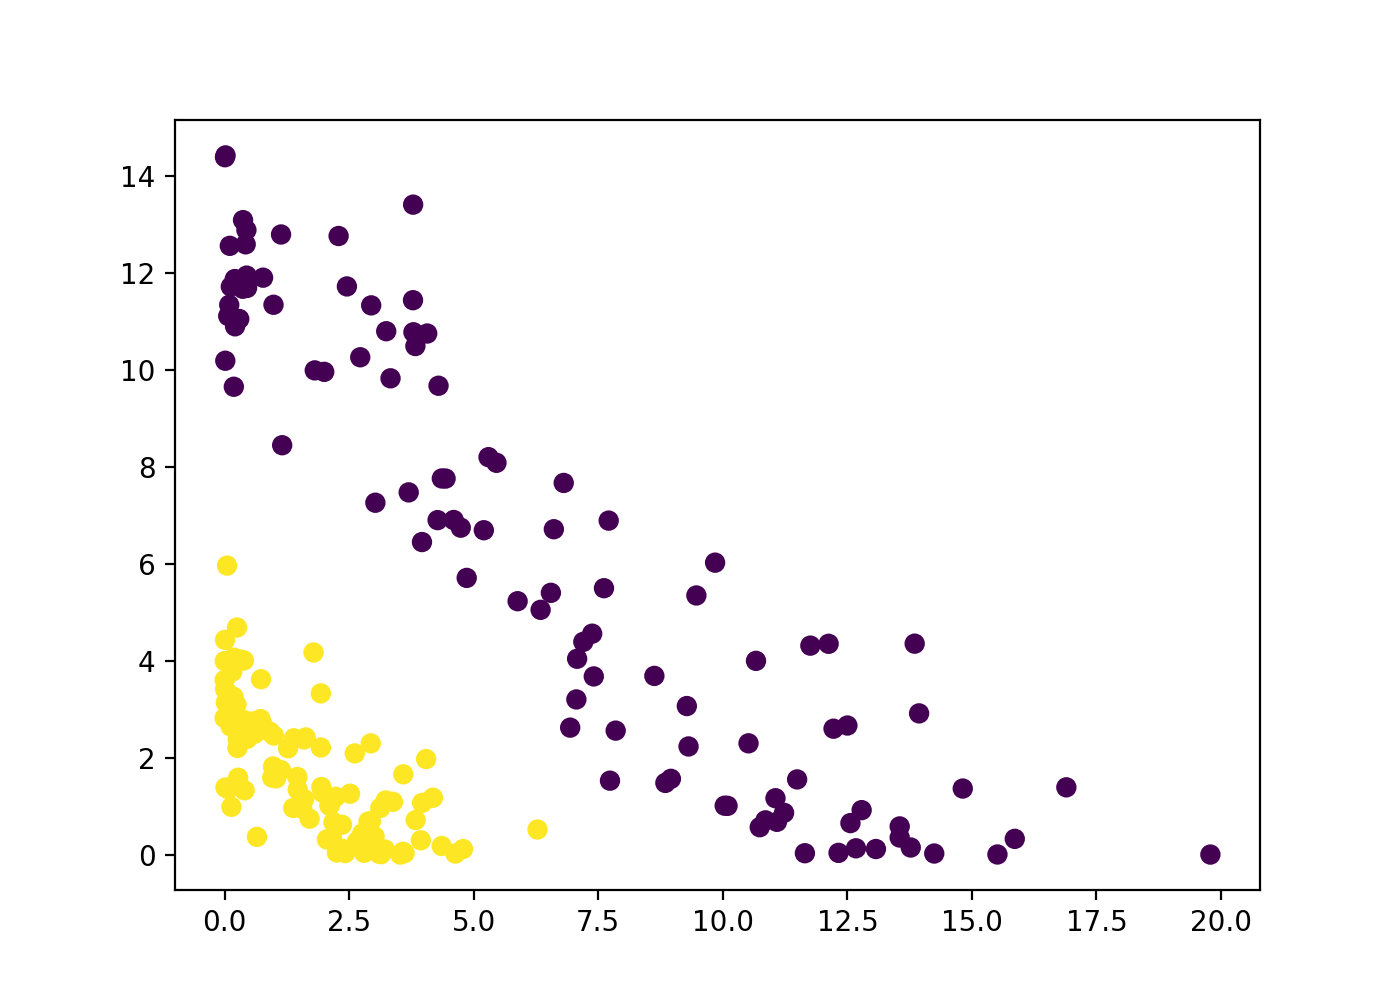

In [122]:
# in case of square function as activation function
fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(H[:,0],H[:,1],s=40,c=y)
plt.savefig('circles_hidden_space_sq.png', dpi=300)
fig.show()

<IPython.core.display.Javascript object>


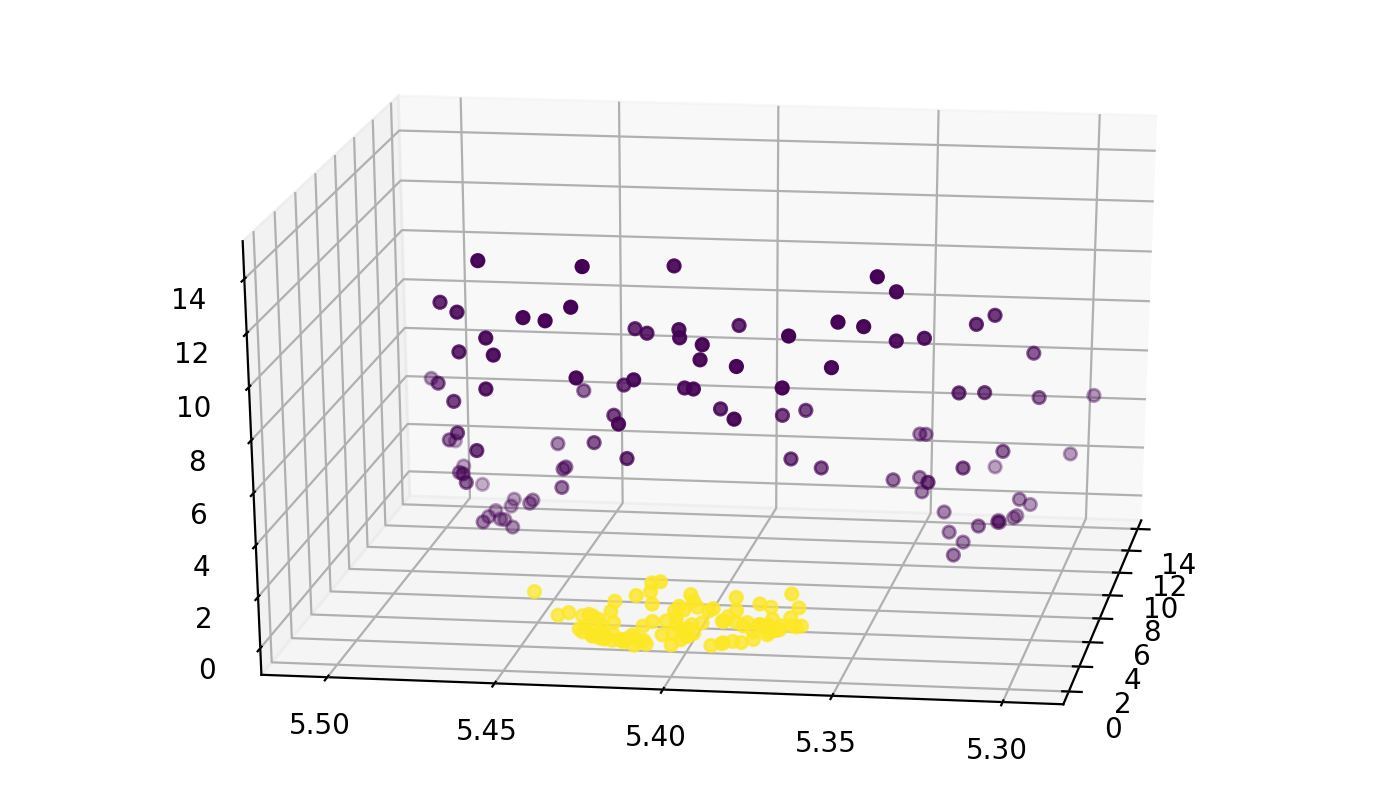

In [87]:
# in case of tanh function as activation function
fig = plt.figure(figsize=(7, 4))
ax = Axes3D(fig)

ax.scatter3D(H[:, 0], H[:, 1], H[:, 2], c=y)
ax.view_init(19, 74)
#plt.savefig('circles_hidden_space_tanh.png', dpi=300)
fig.show()